# UMAPs Seurat samples

In this notebook UMAPs are generated from latent space, CLR transformed protein counts and RNA expression to compare the clustering results. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot
from pySankey import sankey

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


# 1. Preparations

In [2]:
#Retrieving data

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_seurat_norm.h5ad')

In [3]:
adata.obs['cell_type'].unique().tolist()

['Prog_RBC',
 'gdT',
 'CD4 Naive',
 'CD4 Memory',
 'CD14 Mono',
 'Naive B',
 'CD8 Naive',
 'Treg',
 'CD8 Effector_2',
 'NK',
 'GMP',
 'CD8 Effector_1',
 'CD16 Mono',
 'pDC',
 'CD8 Memory_1',
 'MAIT',
 'Memory B',
 'cDC2',
 'CD56 bright NK',
 'Prog_B 2',
 'Prog_Mk',
 'CD8 Memory_2',
 'Plasmablast',
 'HSC',
 'LMPP',
 'Prog_DC',
 'Prog_B 1']

In [3]:
adata.var_names.str.startswith('MT-')

array([False, False, False, ..., False, False, False])

In [4]:
adata = adata.copy()

In [5]:
adata

AnnData object with n_obs × n_vars = 29556 × 8051
    obs: 'cell_type', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'eg_code', 'leiden_r1', 'new_cell_type', 'batch_group'
    uns: 'neighbors', 'new_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_seurat'
    obsp: 'connectivities', 'distances'

In [6]:
adata.obs["POOL"]

a_AAACCTGAGCTTATCG-1    Seurat
a_AAACCTGAGGTGGGTT-1    Seurat
a_AAACCTGAGTACATGA-1    Seurat
a_AAACCTGCAAACCTAC-1    Seurat
a_AAACCTGCAAGGTGTG-1    Seurat
                         ...  
b_TTTGTCATCCGAGCCA-1    Seurat
b_TTTGTCATCCGTAGGC-1    Seurat
b_TTTGTCATCCTCGCAT-1    Seurat
b_TTTGTCATCGCCGTGA-1    Seurat
b_TTTGTCATCGTTTGCC-1    Seurat
Name: POOL, Length: 29556, dtype: category
Categories (1, object): ['Seurat']

In [8]:
#Selecting only one sample

adata =adata[adata.obs['POOL'] == "Seurat"]

In [9]:
adata.shape

(29556, 8051)

In [10]:
#protein information saved

adata_prot=adata.obsm['protein_expression_clr_seurat']

In [11]:
df = adata_prot

In [62]:
df=adata.obsm['protein_expression_clr_seurat'].astype(float)

In [63]:
#selecting nonzero columns (at least some expression detected), these are removed next

nonzero = df.columns[(~(df == 0)).sum() != 0]

In [64]:
#RNA data (zero columns removed) is added to obs 

df=df.loc[:,nonzero]

In [65]:
df.shape

(29556, 25)

In [19]:
#empty anndata file with correct shape (for protein data)

adata_new_prot = ad.AnnData(np.random.poisson(1, size=(df.shape)))

In [20]:
#adata file where X = CLR normalized protein 
adata_new_prot.X=df

In [21]:
#obs and var names identified

adata_new_prot.obs_names = df.index
adata_new_prot.var_names = df.columns

In [22]:
adata_new_prot

AnnData object with n_obs × n_vars = 29556 × 25

In [24]:
#RNA expression to df

df_rna = adata.to_df()

In [25]:
#selecting nonzero columns (at least some expression detected), these are removed next

nonzero = df_rna.columns[(~(df_rna == 0)).sum() != 0]

In [26]:
#RNA data (zero columns removed) is added to obs 

df_rna=adata.to_df().loc[:,nonzero]

In [27]:
df_rna.shape

(29556, 8051)

In [29]:
#empty anndata file with correct shape (for RNA data)

adata_new_rna = ad.AnnData(np.random.poisson(1, size=(df_rna.shape)))

In [30]:
#adata file where X = RNA expression

adata_new_rna.X=df_rna

In [31]:
#obs and var names identified

adata_new_rna.obs_names = df_rna.index
adata_new_rna.var_names = df_rna.columns

In [32]:
adata_new_rna

AnnData object with n_obs × n_vars = 29556 × 8051

In [33]:
import muon as mu

In [34]:
#Combine previous two adata files into one muon object

mdata = mu.MuData({'rna': adata_new_rna, 'adt': adata_new_prot})

In [35]:
mdata.obsm

MuAxisArrays with keys: rna, adt

In [36]:
#anndata file containing only RNA expression
adata_gex = mdata.mod['rna'].copy()

In [37]:
#anndata file containing only CLR normalized protein counts

adata_adt = mdata.mod['adt'].copy()

In [38]:
#Neurips, latent

adata_latent = adata.copy()

In [39]:
adata_adt

AnnData object with n_obs × n_vars = 29556 × 25

In [40]:
adata_latent

AnnData object with n_obs × n_vars = 29556 × 8051
    obs: 'cell_type', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'eg_code', 'leiden_r1', 'new_cell_type', 'batch_group'
    uns: 'neighbors', 'new_cell_type_colors', 'umap'
    obsm: 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_seurat'
    obsp: 'connectivities', 'distances'

In [41]:
a = adata_latent.obs['cell_type']

In [42]:
a

a_AAACCTGAGCTTATCG-1      Prog_RBC
a_AAACCTGAGGTGGGTT-1           gdT
a_AAACCTGAGTACATGA-1     CD4 Naive
a_AAACCTGCAAACCTAC-1    CD4 Memory
a_AAACCTGCAAGGTGTG-1     CD14 Mono
                           ...    
b_TTTGTCATCCGAGCCA-1    CD4 Memory
b_TTTGTCATCCGTAGGC-1     CD4 Naive
b_TTTGTCATCCTCGCAT-1     CD16 Mono
b_TTTGTCATCGCCGTGA-1     CD4 Naive
b_TTTGTCATCGTTTGCC-1     CD8 Naive
Name: cell_type, Length: 29556, dtype: category
Categories (27, object): ['CD4 Memory', 'CD4 Naive', 'CD8 Effector_1', 'CD8 Effector_2', ..., 'Treg', 'cDC2', 'gdT', 'pDC']

In [43]:
#add cell type annotations to protein object

adata_adt.obs["cell_type"] = a

In [44]:
#add cell type annotations to RNA object

adata_gex.obs["cell_type"] = a

## UMAPS

In [45]:
#PCA for RNA and protein

sc.pp.pca(adata_gex)
sc.pp.pca(adata_adt)

In [46]:
#Calculating neighbors for UMAPs

sc.pp.neighbors(adata_latent, use_rep="X_totalVI")   
sc.pp.neighbors(adata_adt) 
sc.pp.neighbors(adata_gex) 

sc.tl.umap(adata_latent)
sc.tl.umap(adata_adt)
sc.tl.umap(adata_gex)

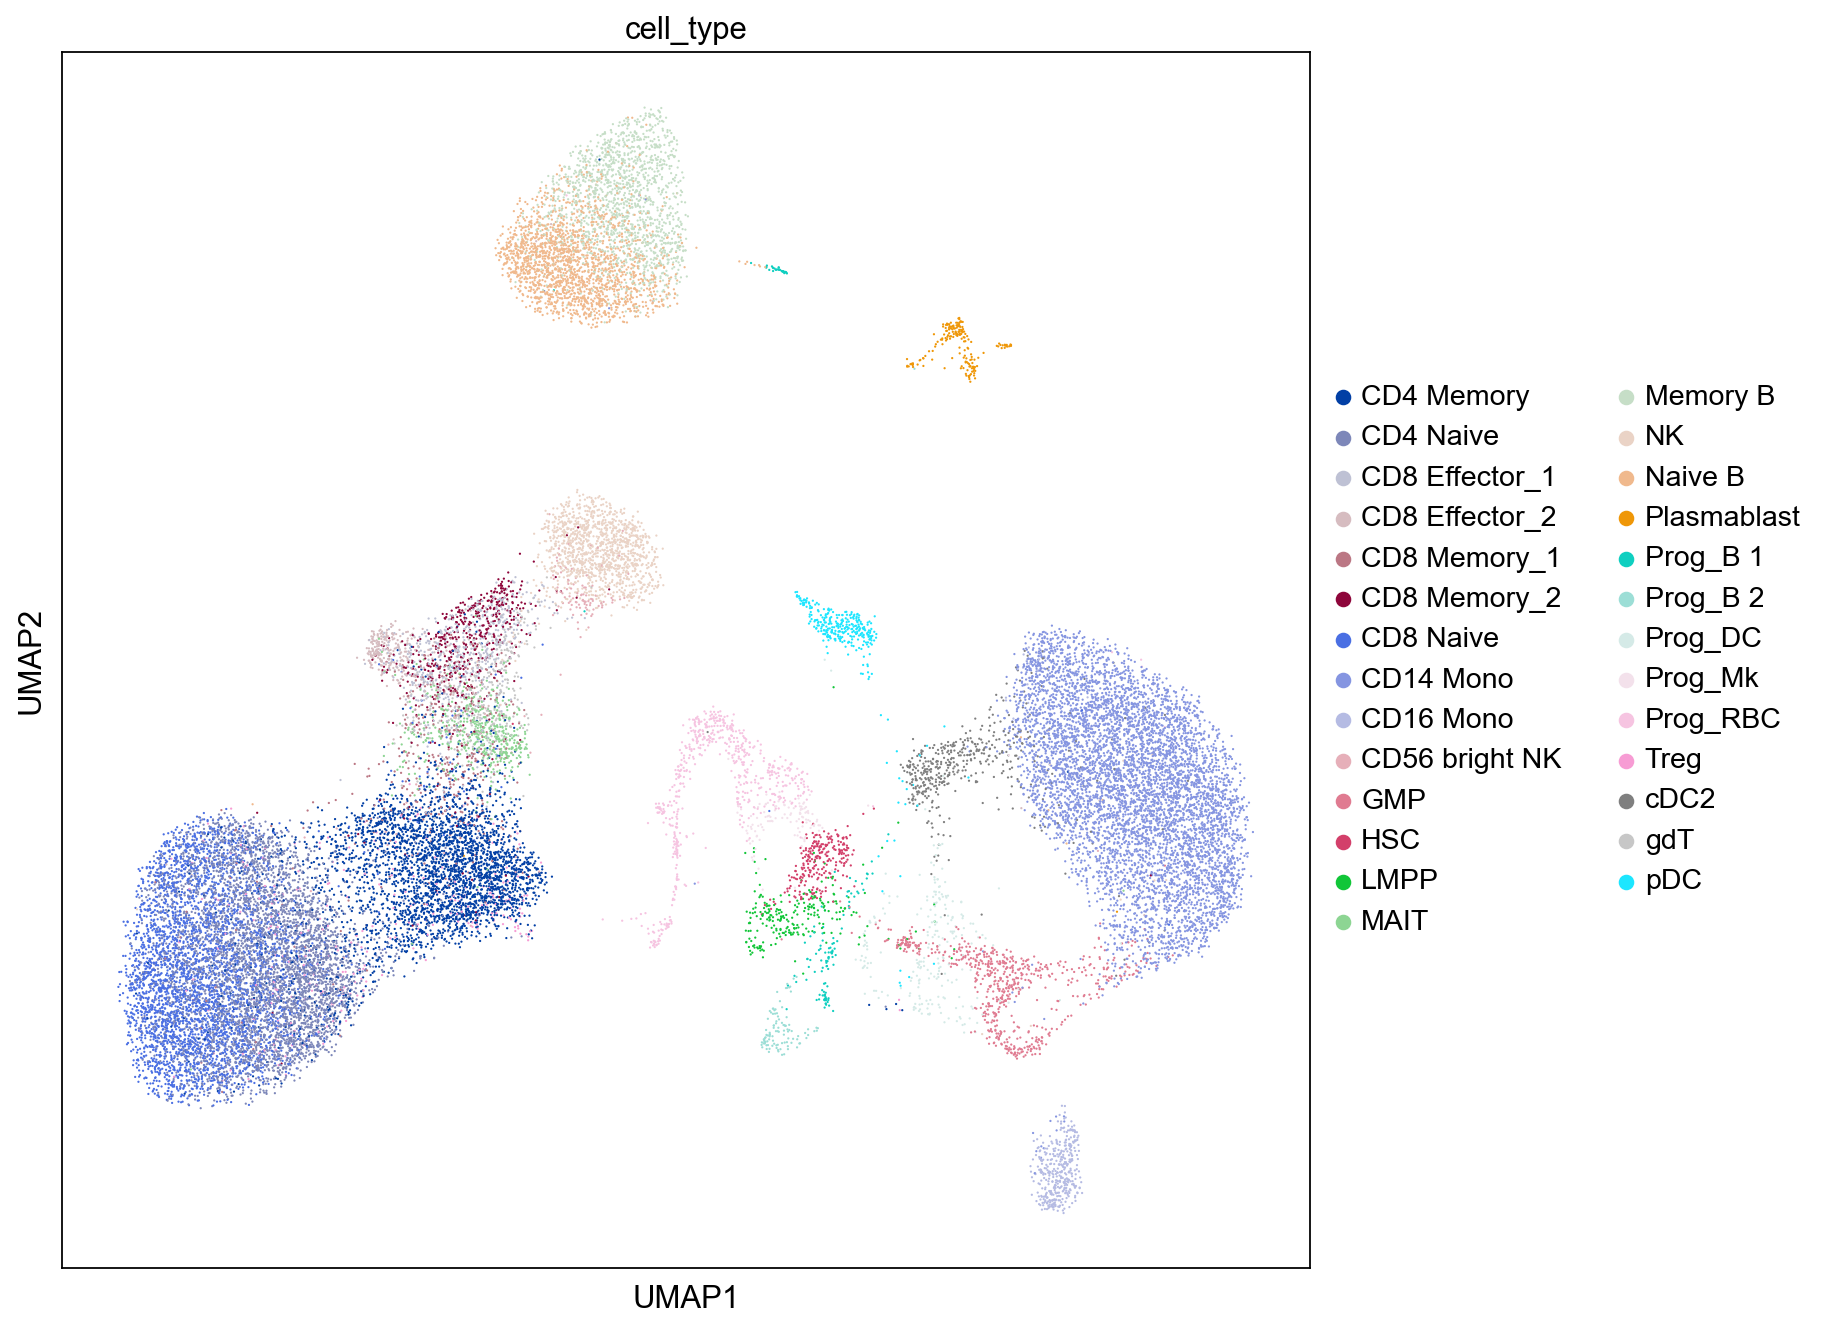

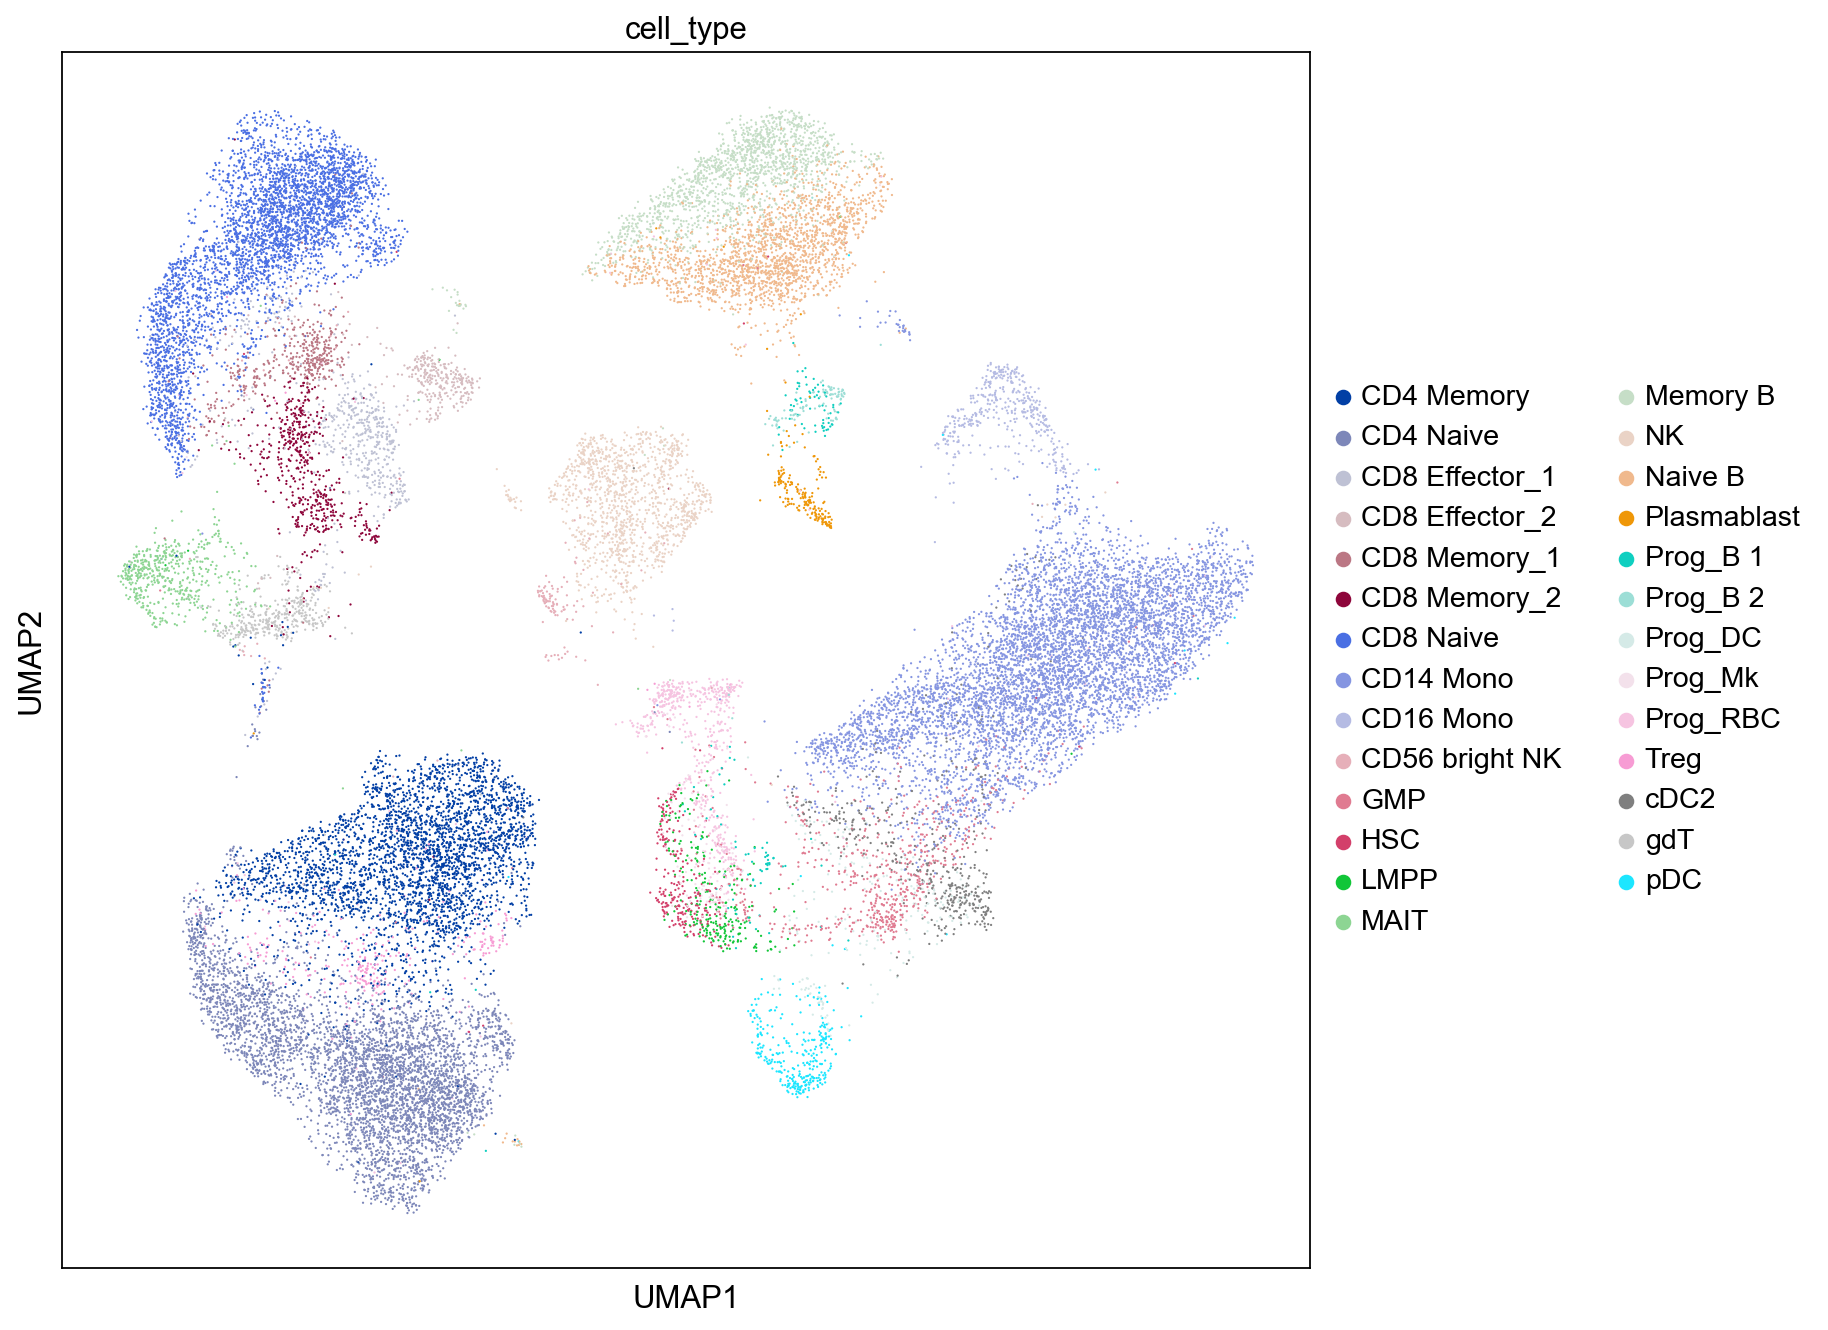

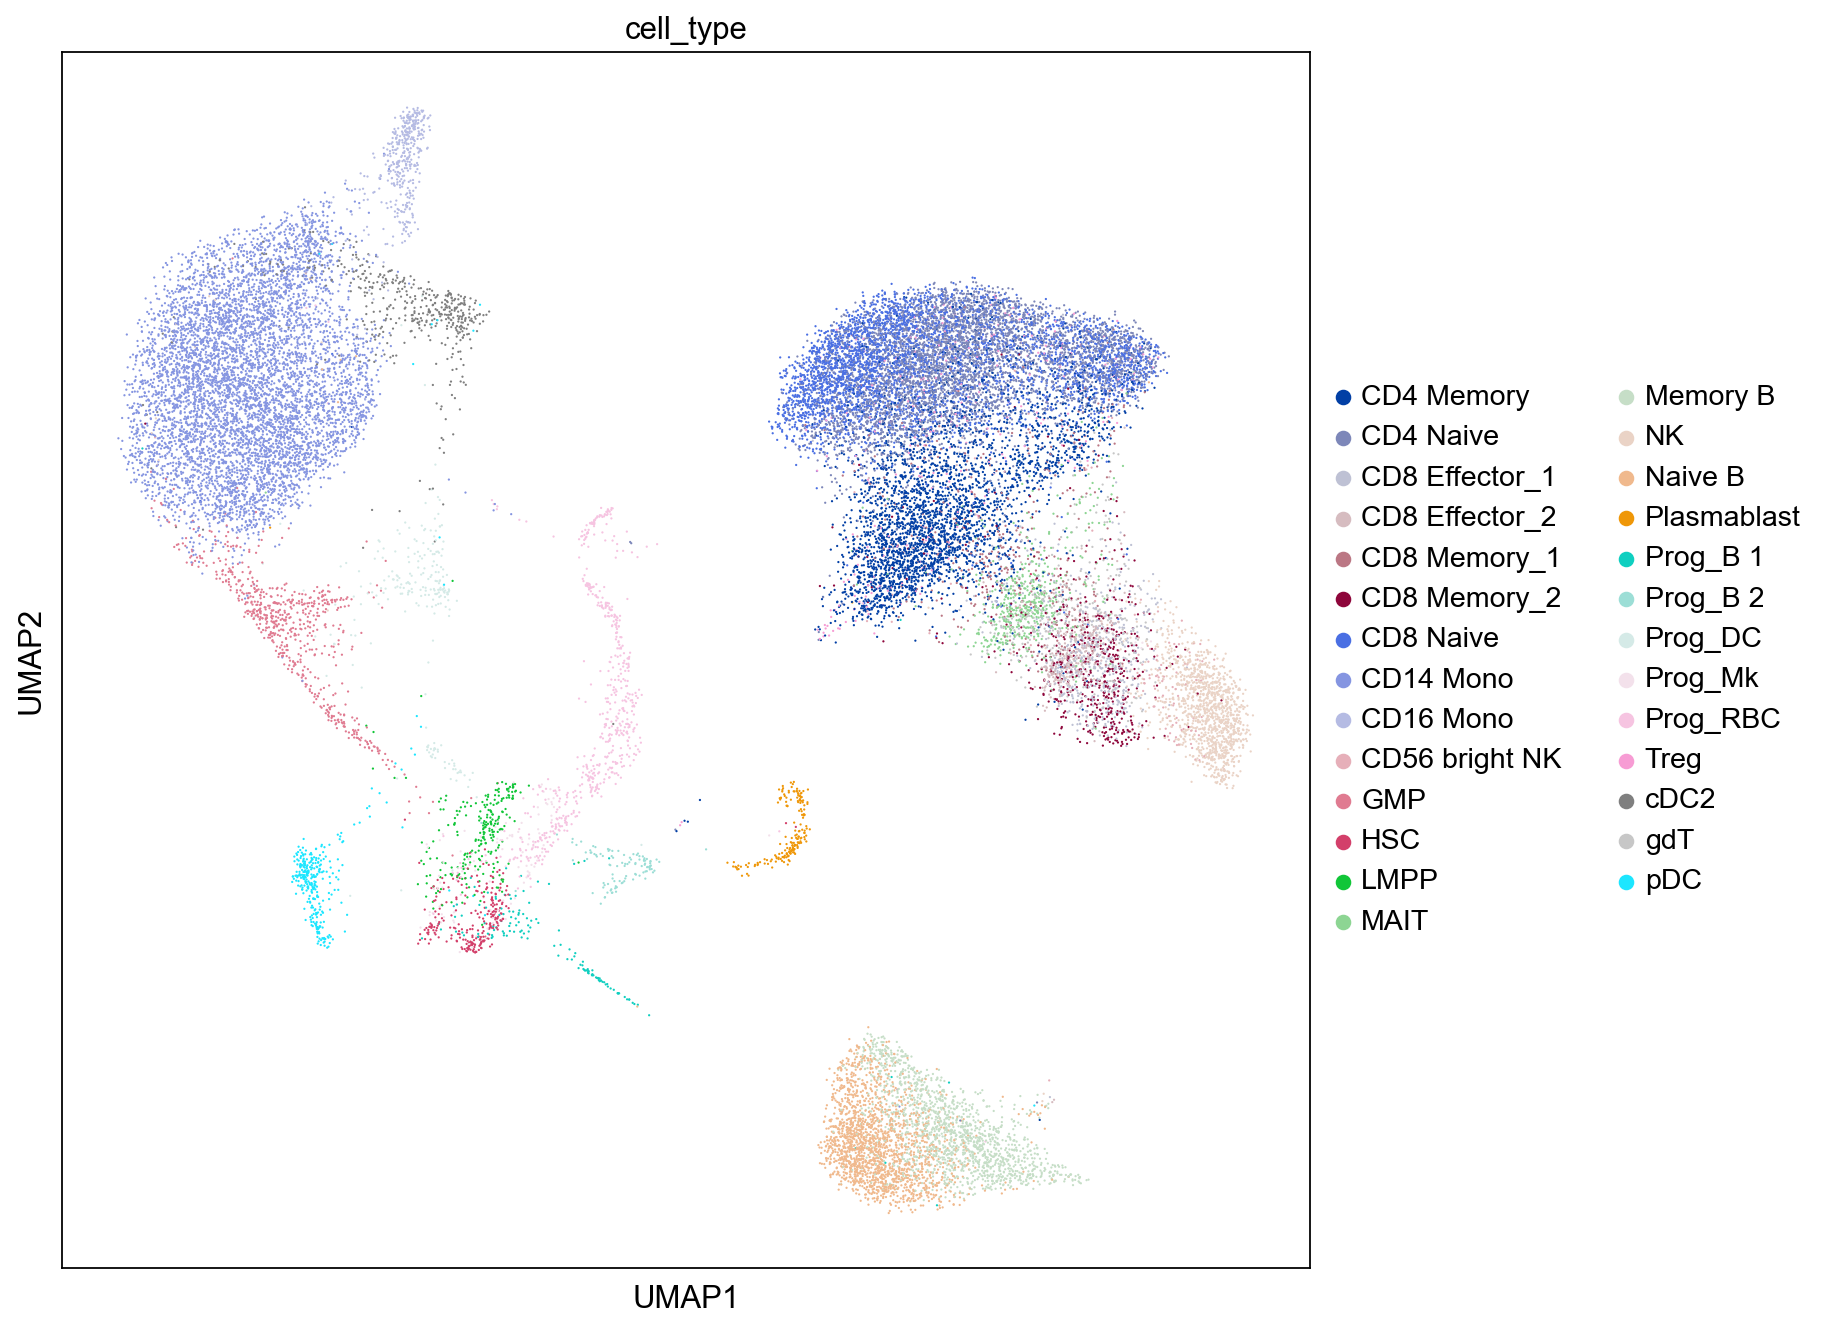

In [48]:
#Showing results in UMAPs

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_latent, color=['cell_type'], ncols =3)
sc.pl.umap(adata_adt, color=['cell_type'], ncols =3)
sc.pl.umap(adata_gex, color=['cell_type'], ncols =3)

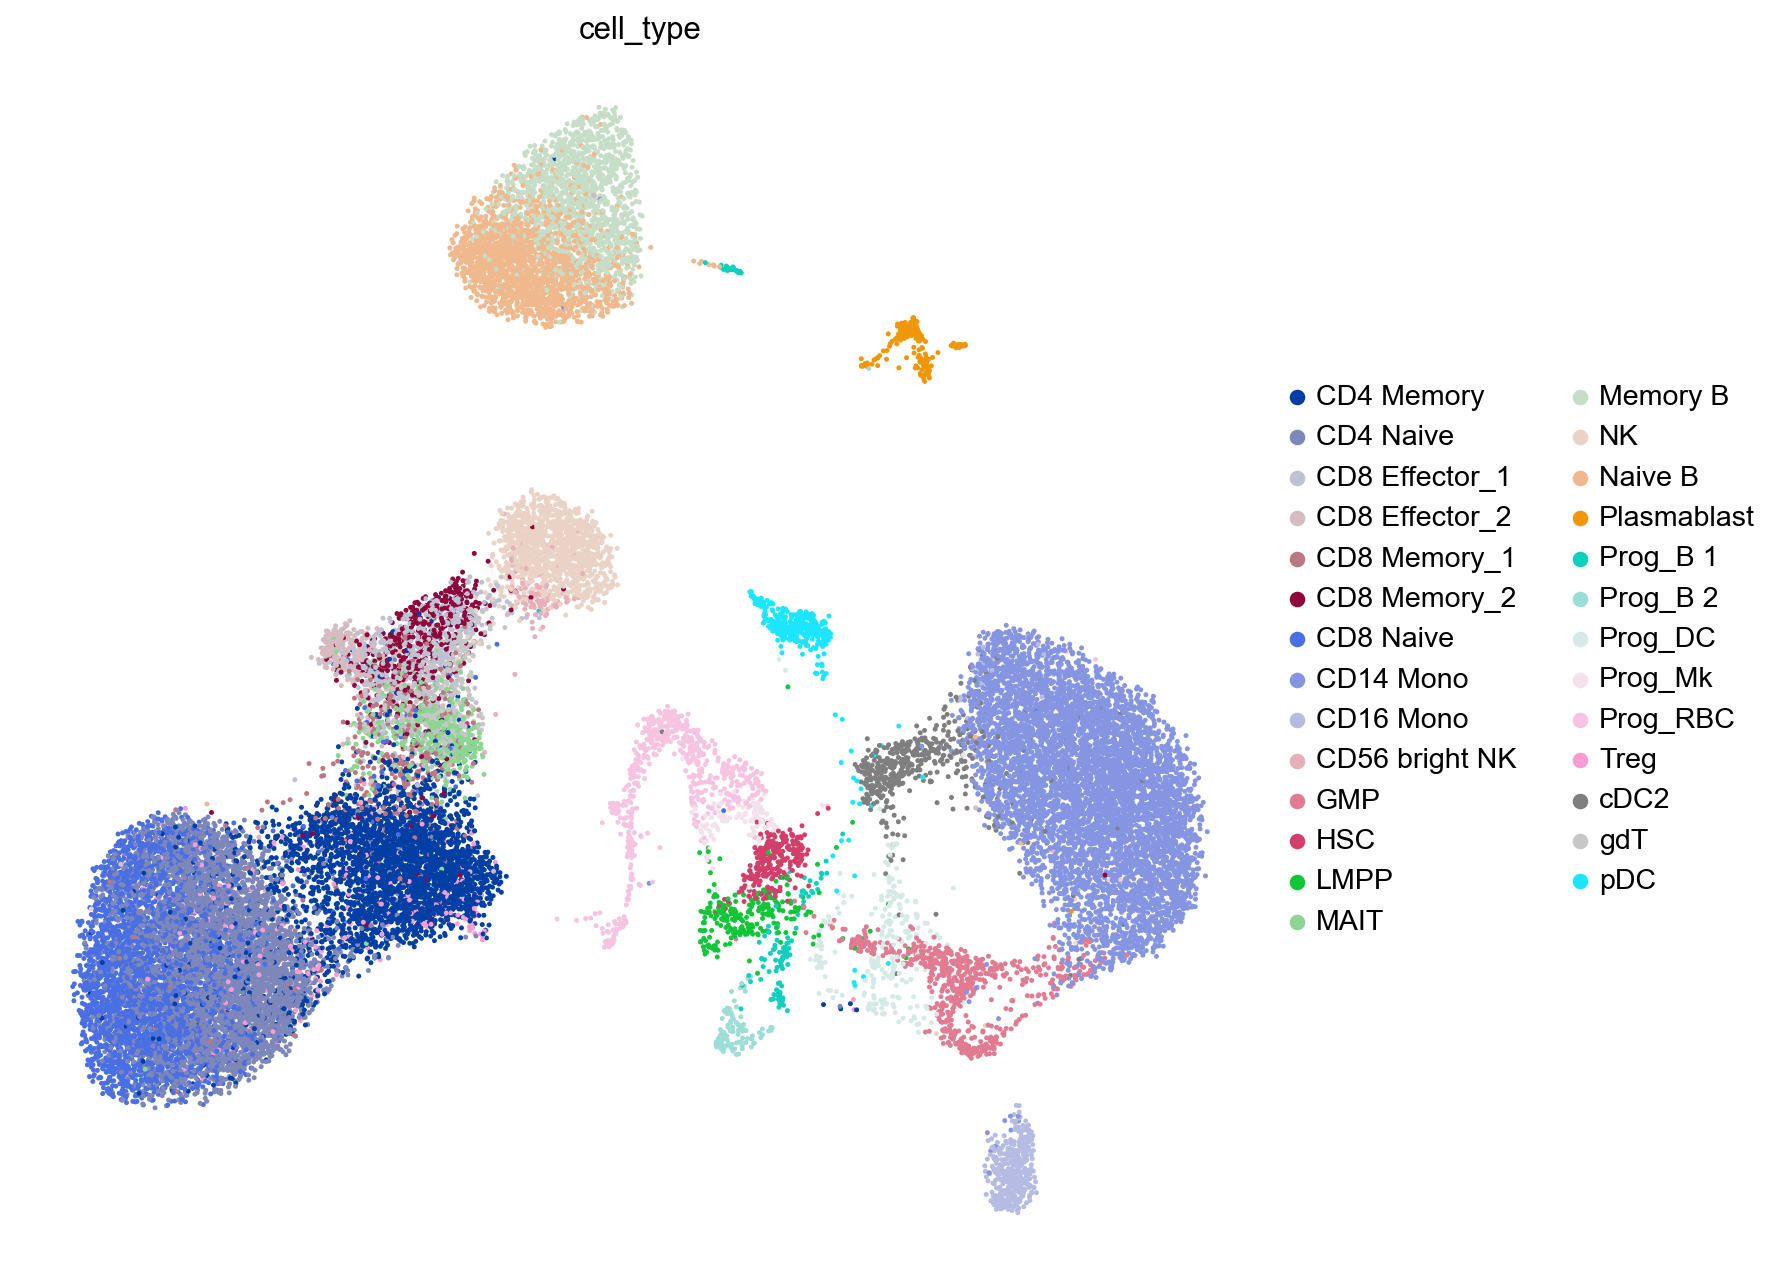

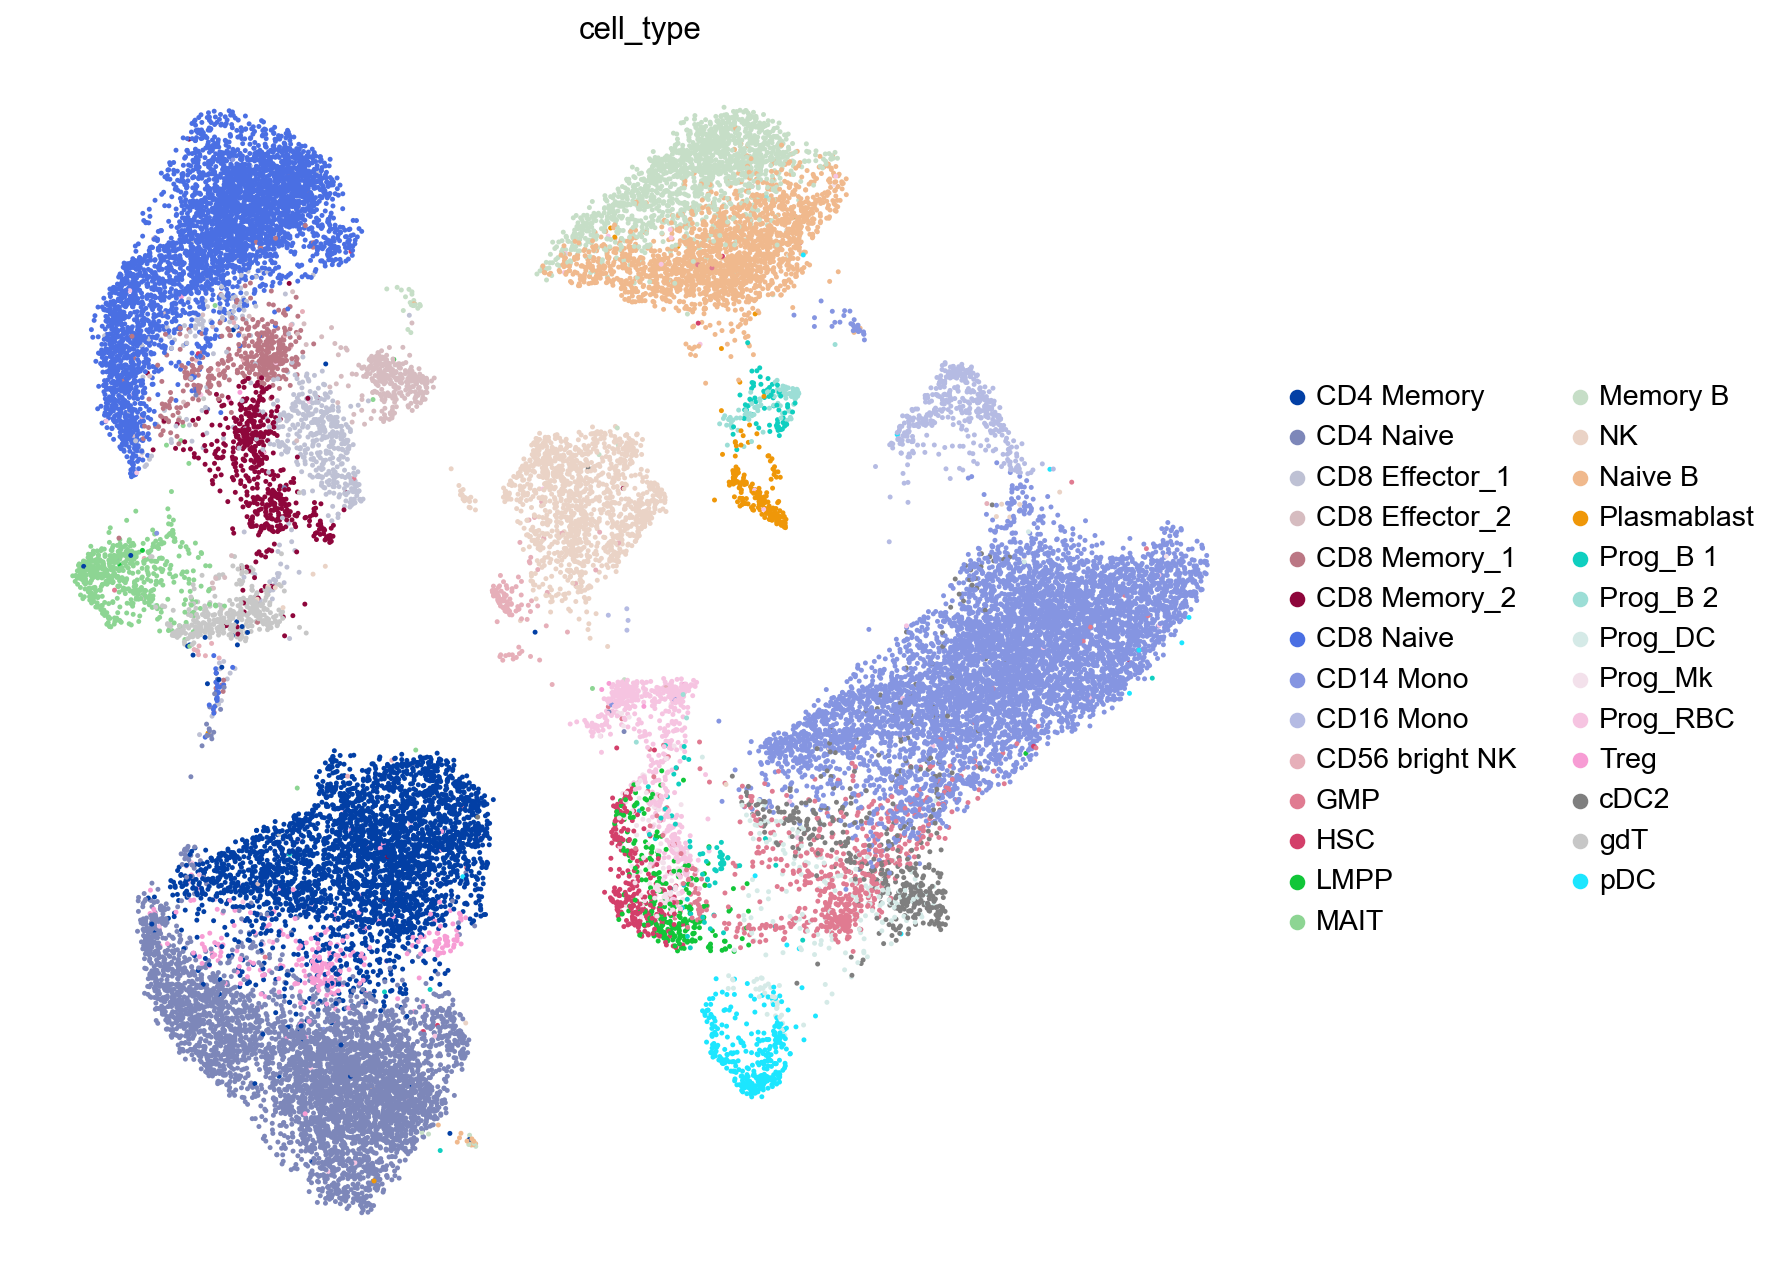

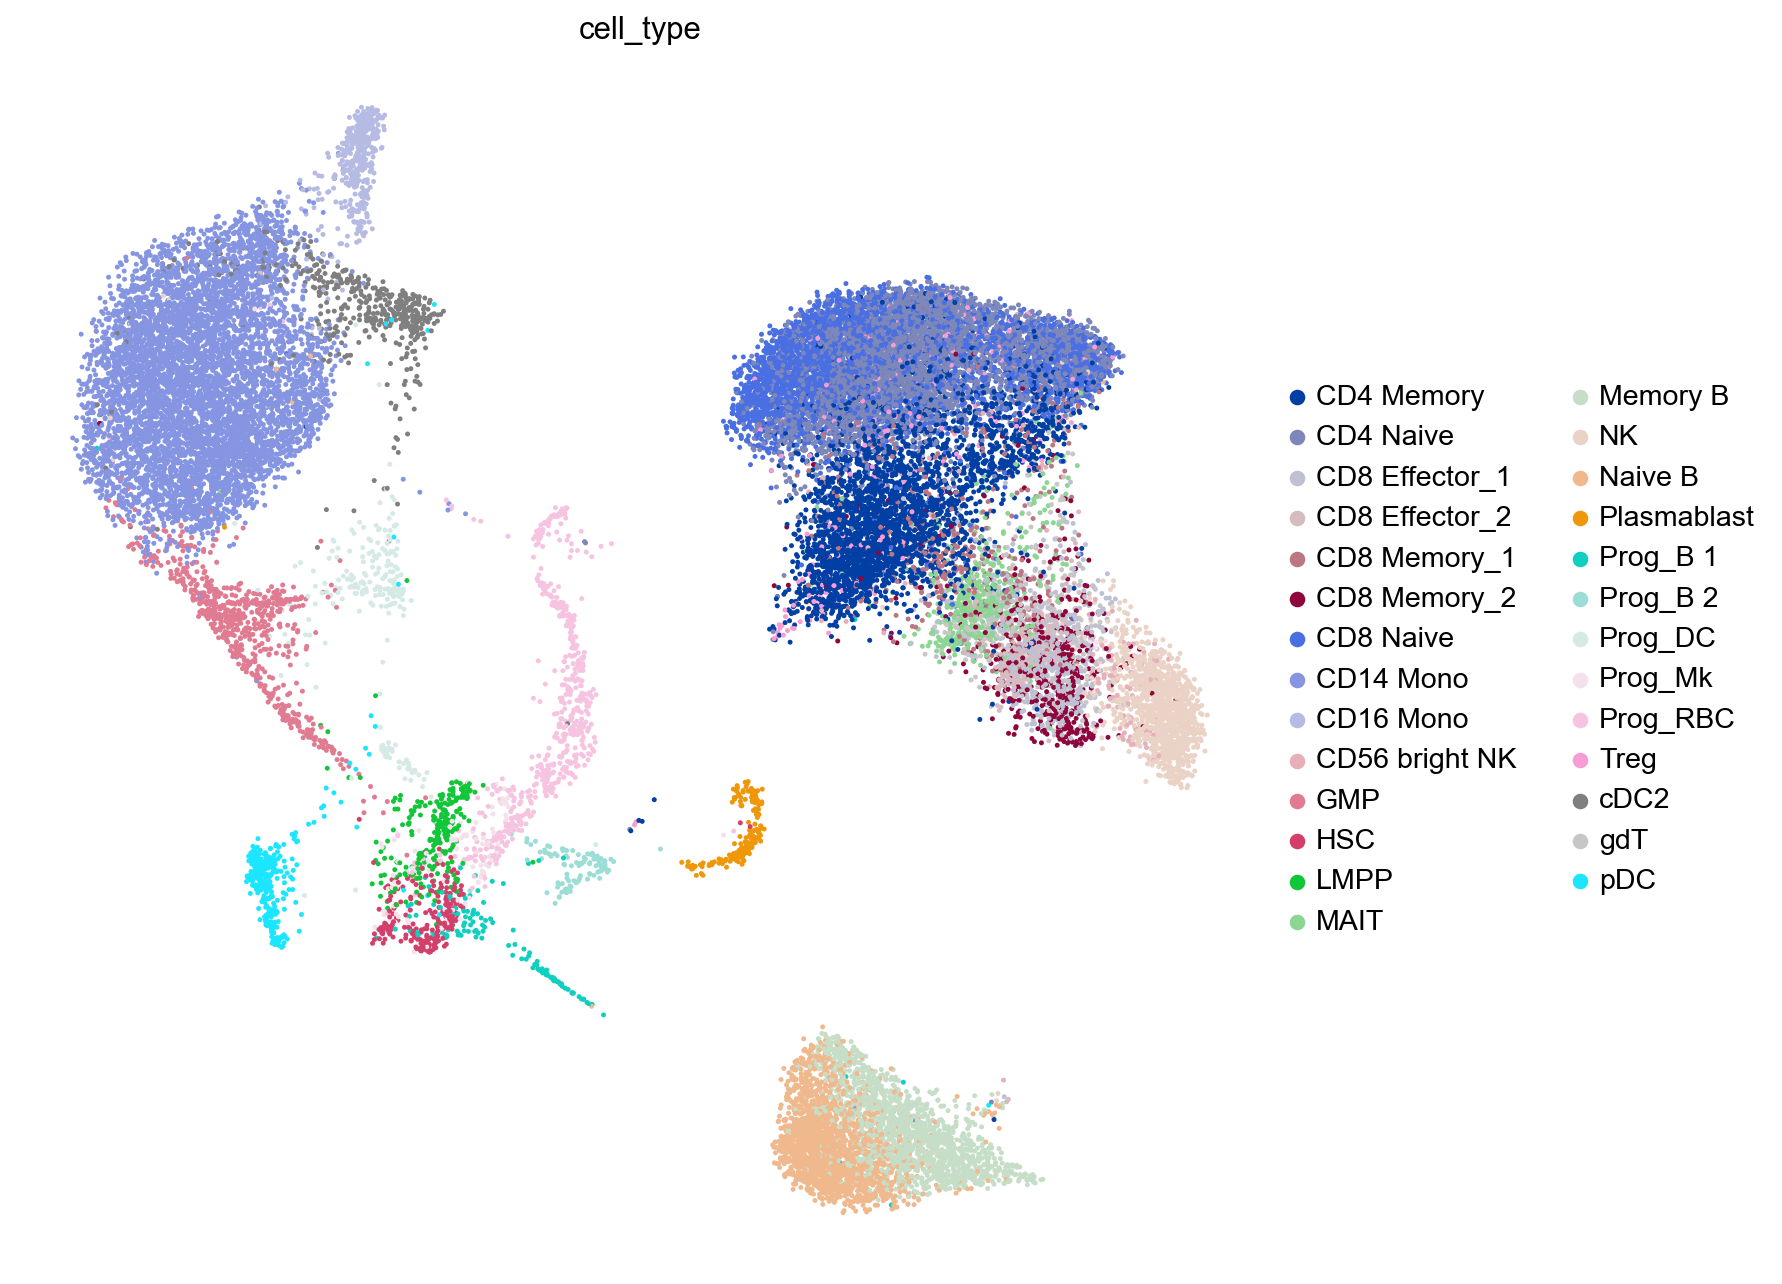

In [50]:
#Showing results in UMAPs

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_latent, color=['cell_type'], ncols =3, frameon=False, size=20)
sc.pl.umap(adata_adt, color=['cell_type'], ncols =3, frameon=False, size=20)
sc.pl.umap(adata_gex, color=['cell_type'], ncols =3, frameon=False, size=20)

In [51]:
adata_latent1 = adata_latent.copy()

In [52]:
neurips_cell_type = adata_latent1.obs['cell_type'].unique().tolist

In [53]:
def replace_cell_type(x):
    if x not in ['NK', 'gdT']:
        return None
    return x

In [54]:
s = adata_latent1.obs.cell_type.apply(replace_cell_type)

adata_latent1.obs['selected_types'] = s

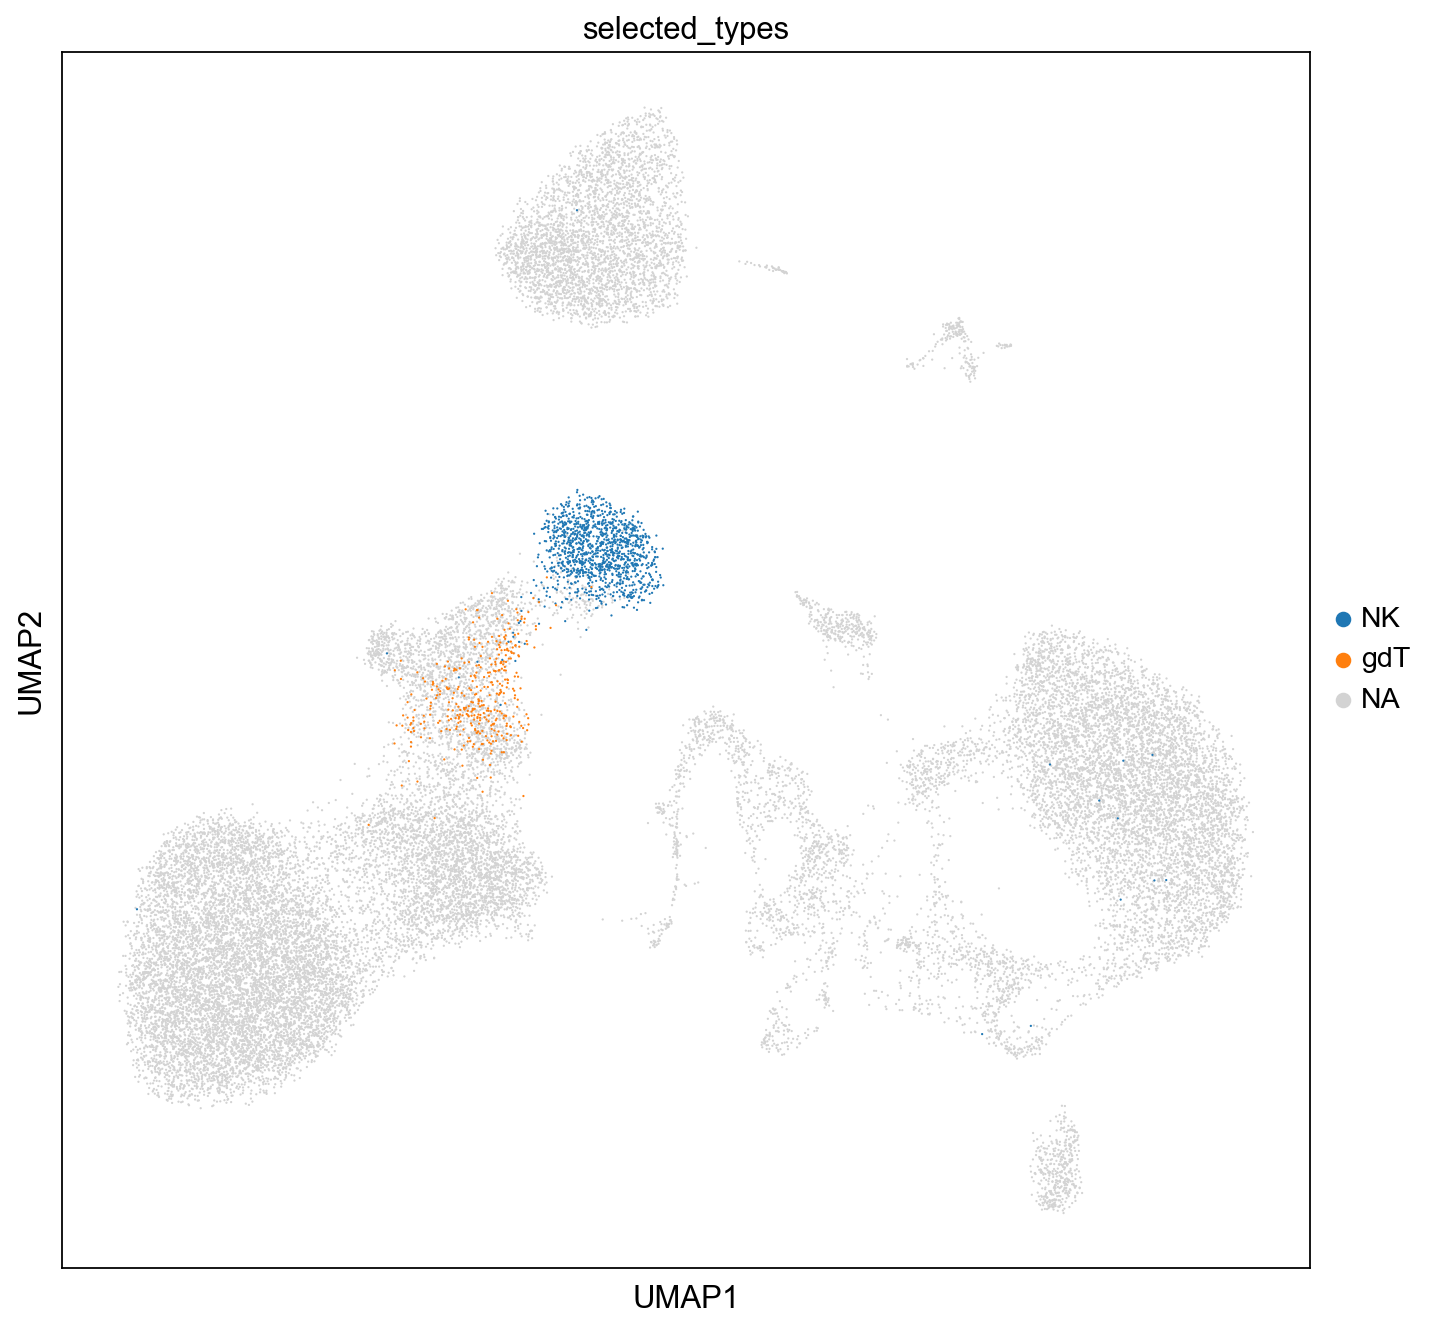

In [55]:
#Whole Neurips dataset plotted

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_latent1, color = ['selected_types'])

In [56]:
adata_gex1 = adata_gex.copy()

In [57]:
s = adata_gex1.obs.cell_type.apply(replace_cell_type)

adata_gex1.obs['selected_types'] = s

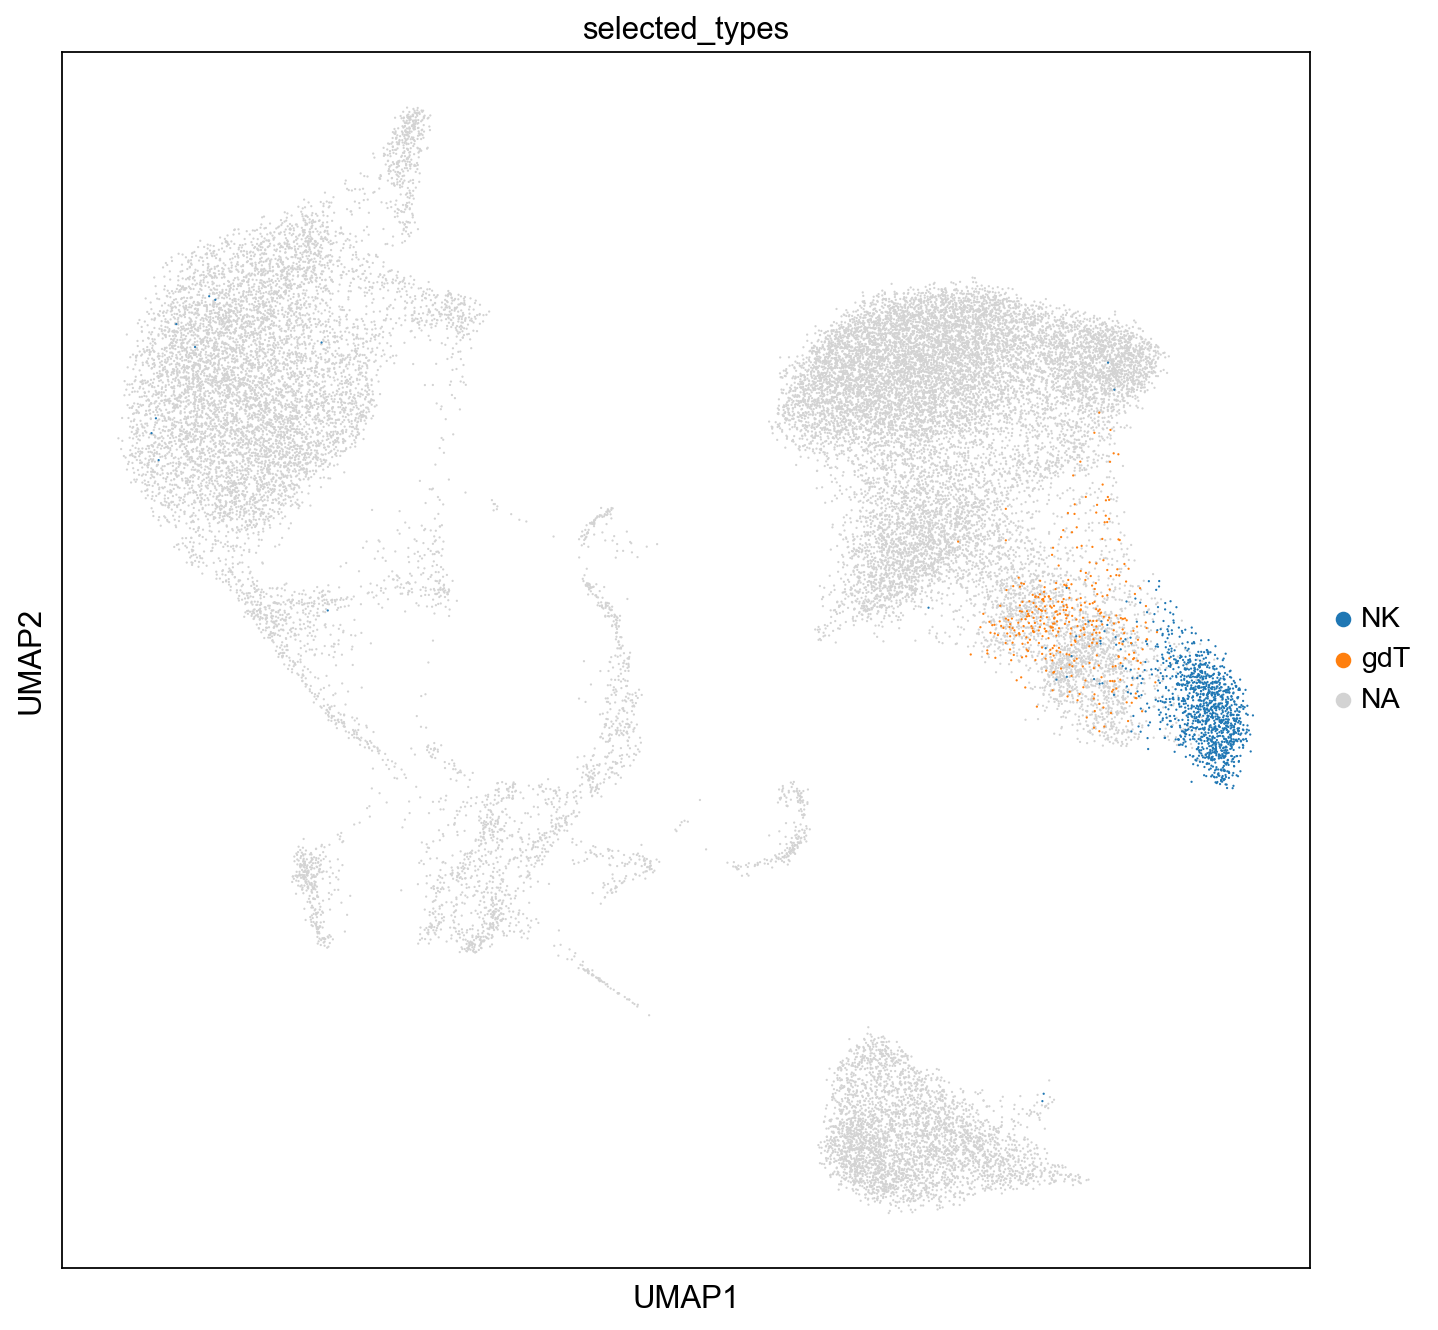

In [58]:
#Whole dataset plotted

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_gex1, color = ['selected_types'])

In [59]:
adata_adt1 = adata_adt.copy()

In [60]:
adata_adt1.obs['selected_types'] = s

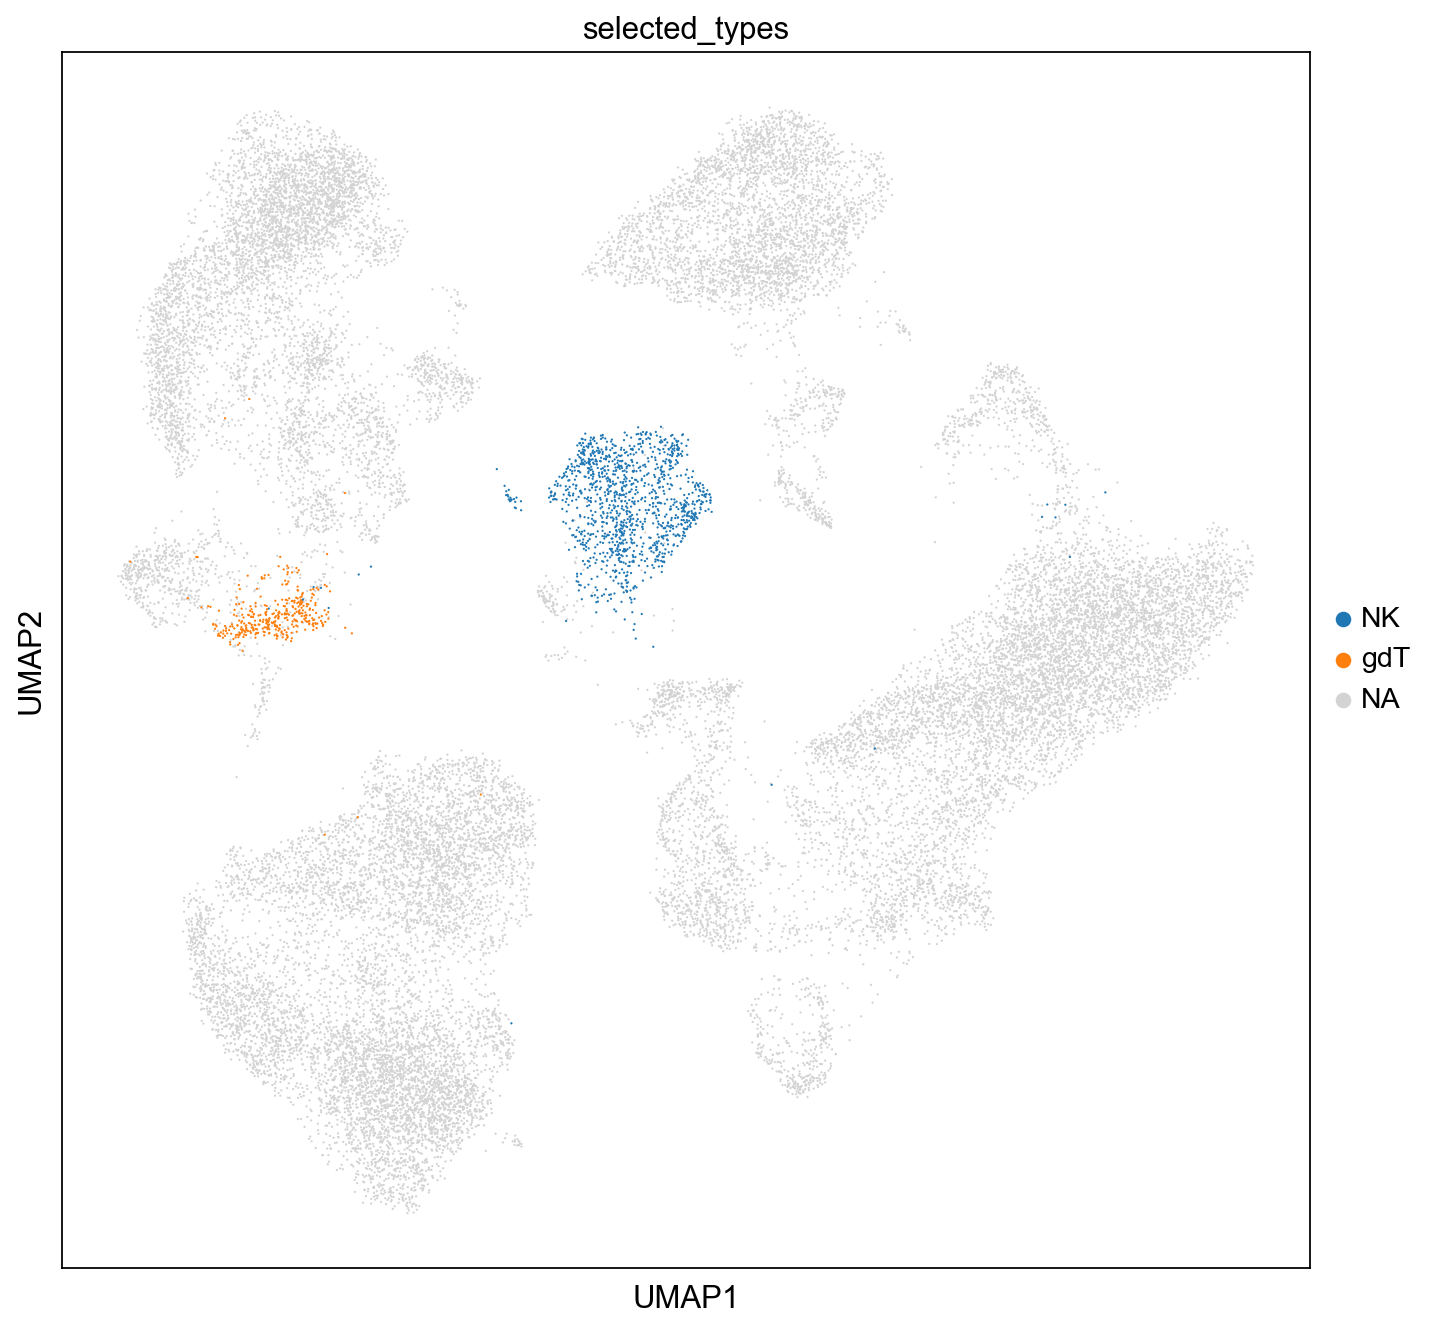

In [61]:
#Whole dataset plotted

sc.set_figure_params(figsize=(10, 10))

sc.pl.umap(adata_adt1, color = ['selected_types'])